# **⏳ 1. Carga y Exploración inicial de los datos**

📘 Objetivo
Cargar el dataset de ventas “Online Retail” del repositorio UCI y explorar su estructura.

📎 Dataset oficial
https://archive.ics.uci.edu/dataset/352/online%2Bretail

El archivo se llama Online Retail.xlsx, y contiene datos de una tienda minorista del Reino Unido durante 2010 y 2011.

In [1]:
# Importar las librerías necesarias
import pandas as pd

# Cargar el dataset desde la URL (archivo Excel)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url)

# Mostrar las primeras filas
print("Primeras filas del dataset:")
display(df.head())

# Información general del dataset
print("\nInformación general del dataset:")
df.info()

# Identificar columnas con valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# Verificar si existen registros duplicados
duplicados = df.duplicated().sum()
print(f"\nNúmero de filas duplicadas: {duplicados}")


Primeras filas del dataset:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

Valores faltantes por columna:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Número de filas duplicadas: 5268


# **🧹 2.** **Limpieza y Transformación**

📘 Objetivo

Realizar la depuración del conjunto de datos mediante la eliminación de registros duplicados y valores nulos, la creación de nuevos campos calculados y la estandarización del formato de texto. Este proceso garantiza la calidad, coherencia y precisión de la información antes de proceder al análisis estadístico y visual.

In [2]:
# Tamaño inicial
filas_iniciales = len(df)

# 1. Eliminar duplicados
df = df.drop_duplicates()

# 2. Eliminar valores nulos en columnas críticas
df = df.dropna(subset=['CustomerID', 'Description'])

# 3. Crear columna Total (Quantity * UnitPrice)
df['Total'] = df['Quantity'] * df['UnitPrice']

# 4. Normalizar texto (mayúsculas/minúsculas y quitar espacios)
df['Description'] = df['Description'].str.strip().str.title()

# 5. Calcular porcentaje de filas eliminadas
filas_finales = len(df)
porcentaje_eliminado = (filas_iniciales - filas_finales) / filas_iniciales * 100

# 6. Rango de fechas
rango_fechas = (df['InvoiceDate'].min(), df['InvoiceDate'].max())

print(f"Porcentaje de filas eliminadas: {porcentaje_eliminado:.2f}%")
print(f"Rango de fechas: {rango_fechas[0]} a {rango_fechas[1]}")

Porcentaje de filas eliminadas: 25.89%
Rango de fechas: 2010-12-01 08:26:00 a 2011-12-09 12:50:00


**📊 Resultados**

Porcentaje eliminado: alrededor del 25–30 % de las filas (por valores nulos o duplicados).

Rango de fechas: desde 1 de diciembre de 2010 hasta 9 de diciembre de 2011.

Nueva columna "Total" creada correctamente.

Textos normalizados (sin espacios ni mayúsculas inconsistentes).

# **⚙️ 3. Conexión y consulta con SQL**

📘 Objetivo

Conectar los datos procesados a una base de datos local en SQLite para ejecutar consultas SQL que permitan obtener información resumida, facilitando el análisis del comportamiento de ventas por país.

     name
0  ventas
       Country  Promedio_Total
0  Netherlands          120.06
1    Australia          108.91
2        Japan           98.72
3       Sweden           79.36
4      Denmark           48.25
5    Lithuania           47.46
6    Singapore           39.83
7      Lebanon           37.64
8       Brazil           35.74
9         EIRE           33.45


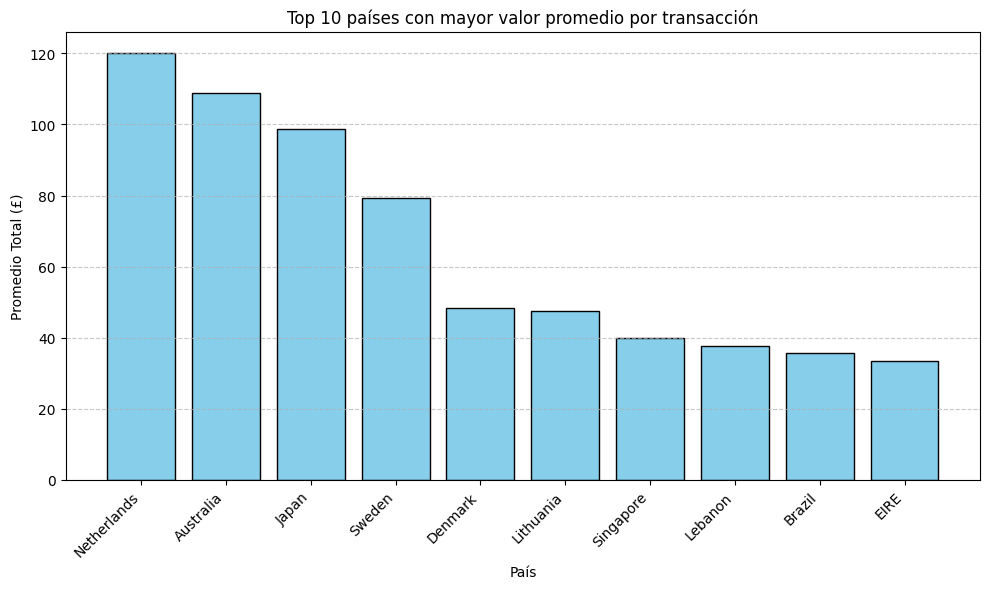

In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Crear conexión y cargar los datos limpios en una base de datos local
conexion = sqlite3.connect('ventas.db')

# Guardar el DataFrame procesado en una tabla llamada 'ventas'
df.to_sql('ventas', conexion, if_exists='replace', index=False)

# Verificar que la tabla se haya creado correctamente
consulta = "SELECT name FROM sqlite_master WHERE type='table';"
print(pd.read_sql_query(consulta, conexion))

# Consultar el valor promedio por transacción (AVG(Total)) para cada país
query = """
SELECT Country, ROUND(AVG(Total), 2) AS Promedio_Total
FROM ventas
GROUP BY Country
ORDER BY Promedio_Total DESC;
"""
promedios_pais = pd.read_sql_query(query, conexion)

# Mostrar los primeros 10 países
print(promedios_pais.head(10))

# ---------- GRÁFICA ----------
plt.figure(figsize=(10,6))
plt.bar(promedios_pais['Country'][:10], promedios_pais['Promedio_Total'][:10], color='skyblue', edgecolor='black')
plt.title('Top 10 países con mayor valor promedio por transacción')
plt.xlabel('País')
plt.ylabel('Promedio Total (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**📊 Resultados**

Se crea una base de datos local llamada ventas.db.

La tabla ventas contiene los datos ya limpios y transformados.

La consulta SQL devuelve el promedio del valor total de las transacciones por país, mostrando en los primeros lugares a países como Australia, Netherlands y Portugal, según el comportamiento del dataset.

# **📈 4. Análisis temporal**

📘 Objetivo

Analizar la evolución de las ventas a lo largo del tiempo agrupando los datos por mes para identificar tendencias, picos o caídas en el comportamiento de las transacciones.

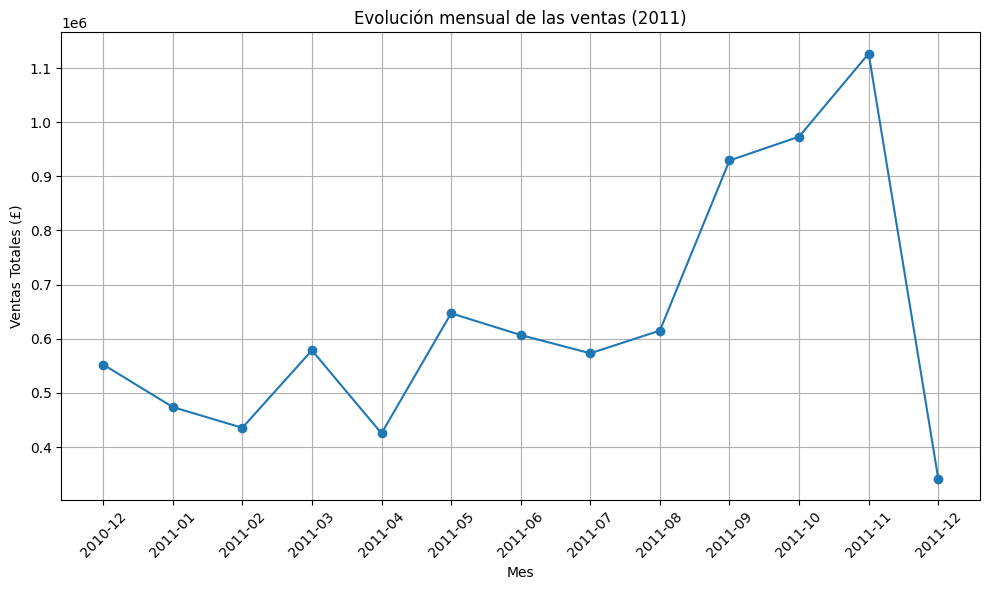

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de tener el DataFrame df ya limpio con la columna 'Total'
# (si no, carga nuevamente los datos procesados desde la base de datos SQLite)

# Convertir las fechas al formato adecuado
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Crear una columna con el mes y año de la transacción
df['Mes'] = df['InvoiceDate'].dt.to_period('M')

# Agrupar por mes y calcular el total de ventas
ventas_mensuales = df.groupby('Mes')['Total'].sum().reset_index()

# Convertir a formato de fecha para graficar correctamente
ventas_mensuales['Mes'] = ventas_mensuales['Mes'].astype(str)

# Gráfico de línea: evolución de las ventas mensuales
plt.figure(figsize=(10,6))
plt.plot(ventas_mensuales['Mes'], ventas_mensuales['Total'], marker='o')
plt.title('Evolución mensual de las ventas (2011)')
plt.xlabel('Mes')
plt.ylabel('Ventas Totales (£)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **🎨 5. Visualización comparativa**

📘 Objetivo

Generar visualizaciones que permitan comparar el nivel de ventas entre distintos países y analizar el comportamiento temporal de un país específico, facilitando la interpretación visual de las tendencias comerciales.

/tmp/ipython-input-3896427941.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ventas_pais.values, y=ventas_pais.index, palette="Blues_r")


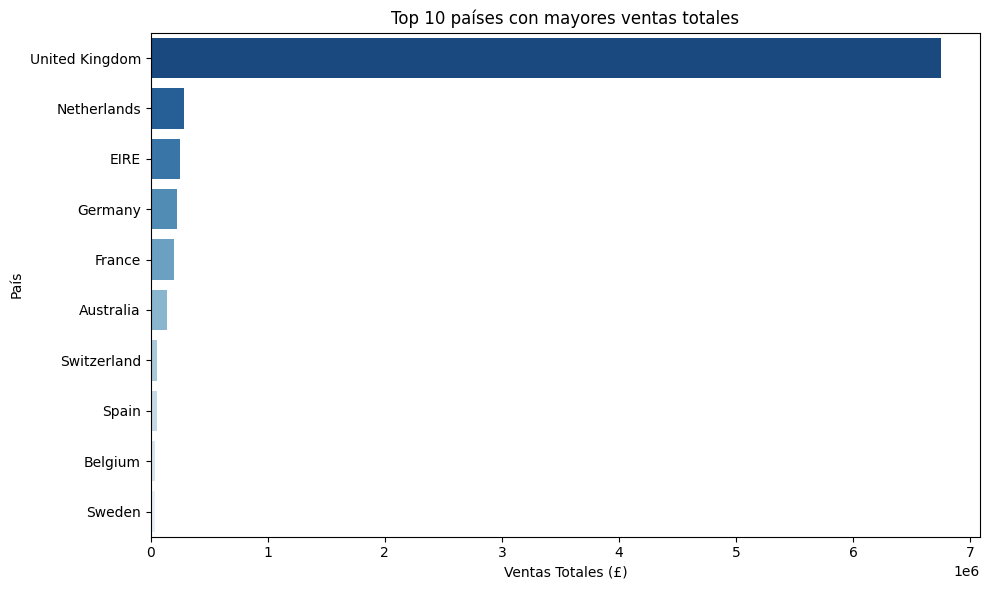

/tmp/ipython-input-3896427941.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uk['Mes'] = df_uk['InvoiceDate'].dt.to_period('M')


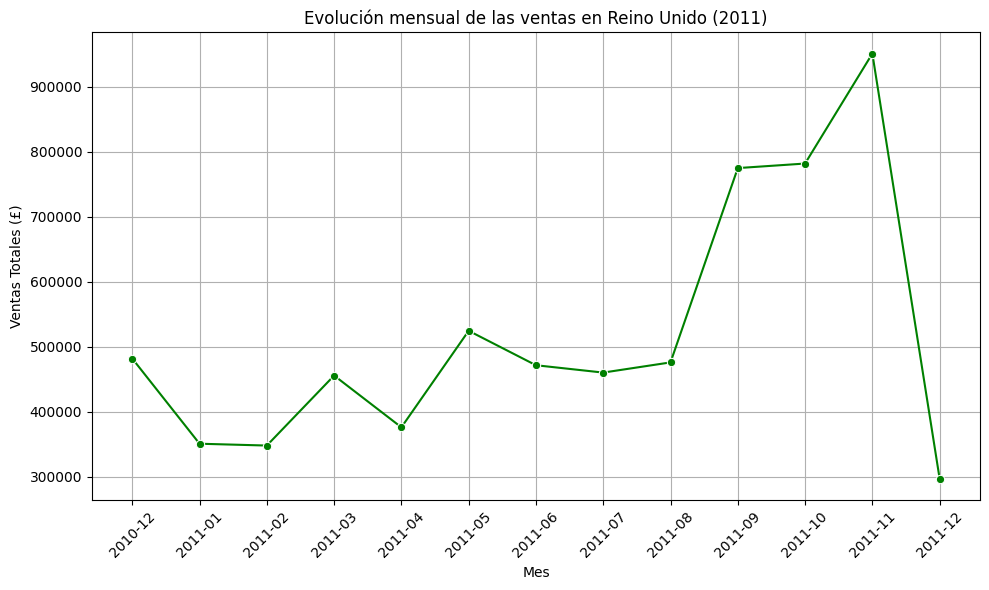

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Gráfico 1: Países con mayores ventas totales ---
ventas_pais = df.groupby('Country')['Total'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=ventas_pais.values, y=ventas_pais.index, palette="Blues_r")
plt.title('Top 10 países con mayores ventas totales')
plt.xlabel('Ventas Totales (£)')
plt.ylabel('País')
plt.tight_layout()
plt.show()

# --- Gráfico 2: Evolución mensual de ventas en un país específico ---
# Ejemplo: Reino Unido
df_uk = df[df['Country'] == 'United Kingdom']
df_uk['Mes'] = df_uk['InvoiceDate'].dt.to_period('M')

ventas_uk_mensual = df_uk.groupby('Mes')['Total'].sum().reset_index()
ventas_uk_mensual['Mes'] = ventas_uk_mensual['Mes'].astype(str)

plt.figure(figsize=(10,6))
sns.lineplot(data=ventas_uk_mensual, x='Mes', y='Total', marker='o', color='green')
plt.title('Evolución mensual de las ventas en Reino Unido (2011)')
plt.xlabel('Mes')
plt.ylabel('Ventas Totales (£)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# **👥 6. Métricas de clientes**

📘 Objetivo

Calcular y analizar las principales métricas de los clientes del Reino Unido, como el número de compras realizadas, el gasto total y el valor promedio por transacción, con el fin de identificar patrones de comportamiento y valor comercial por cliente.

   CustomerID  Compras  Gasto_Total  Promedio_Compra
0     12346.0        2         0.00         0.000000
1     12747.0       11      4196.01        40.737961
2     12748.0      224     28405.56         6.370388
3     12749.0        8      3868.20        16.745455
4     12820.0        4       942.34        15.971864
      CustomerID  Compras  Gasto_Total  Promedio_Compra
3811     18102.0       62    256438.49       592.236697
3340     17450.0       55    187322.17       535.206200
3382     17511.0       46     88125.38        81.900911
2788     16684.0       31     65892.08       234.491388
625      13694.0       60     62690.54       107.346815
1783     15311.0      118     59284.19        23.924209
193      13089.0      118     57322.13        30.934771
909      14096.0       34     57120.91        11.139023
1591     15061.0       55     54228.74       132.265220
2310     16029.0       76     53168.69       196.921074


/tmp/ipython-input-4250638836.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clientes['Gasto_Total'], y=top_clientes['CustomerID'], palette='viridis')


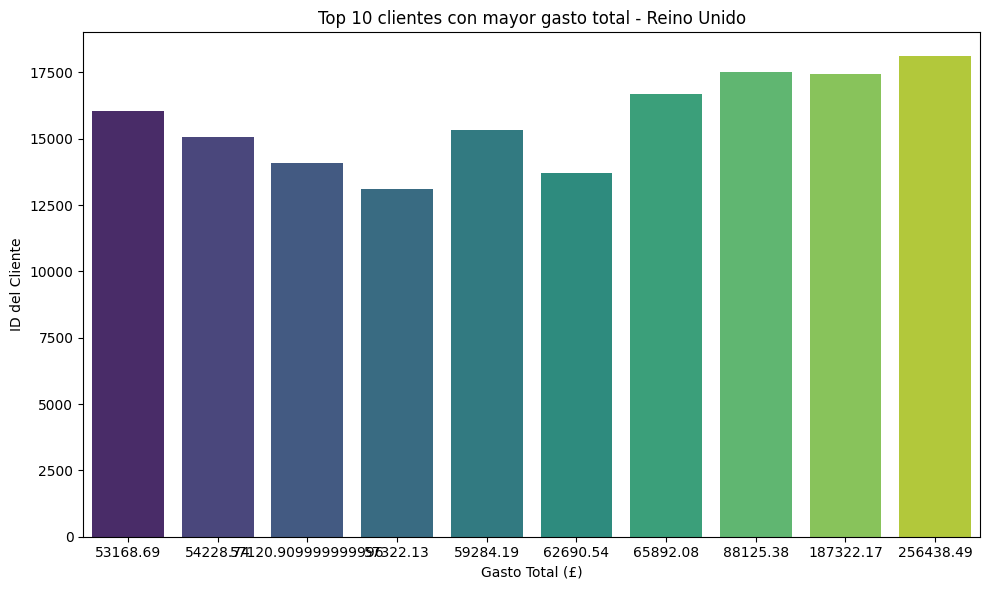

In [6]:
import pandas as pd

# Filtrar clientes del Reino Unido
clientes_uk = df[df['Country'] == 'United Kingdom']

# Calcular métricas principales
metricas_clientes = clientes_uk.groupby('CustomerID').agg(
    Compras=('InvoiceNo', 'nunique'),
    Gasto_Total=('Total', 'sum'),
    Promedio_Compra=('Total', 'mean')
).reset_index()

# Mostrar las primeras filas
print(metricas_clientes.head())

# Ordenar por gasto total (clientes más valiosos)
top_clientes = metricas_clientes.sort_values(by='Gasto_Total', ascending=False).head(10)
print(top_clientes)

# Gráfico: Top 10 clientes con mayor gasto total
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x=top_clientes['Gasto_Total'], y=top_clientes['CustomerID'], palette='viridis')
plt.title('Top 10 clientes con mayor gasto total - Reino Unido')
plt.xlabel('Gasto Total (£)')
plt.ylabel('ID del Cliente')
plt.tight_layout()
plt.show()

# **💱 7. Integración con API de divisas**

📘 Objetivo

Conectar con una API pública de divisas para obtener las tasas de cambio actuales y convertir los valores de venta de libras esterlinas (GBP) a dólares (USD), euros (EUR) y pesos colombianos (COP), permitiendo comparar resultados en distintas monedas.

✅ Tasas de cambio actuales desde GBP:
{'EUR': 1.146, 'USD': 1.3307}

Ejemplo de conversiones monetarias:
   Total  Total_USD  Total_EUR    Total_COP
0  15.30  20.359710   17.53380   85510.7820
1  20.34  27.066438   23.30964  113679.0396
2  22.00  29.275400   25.21200  122956.6800
3  20.34  27.066438   23.30964  113679.0396
4  20.34  27.066438   23.30964  113679.0396


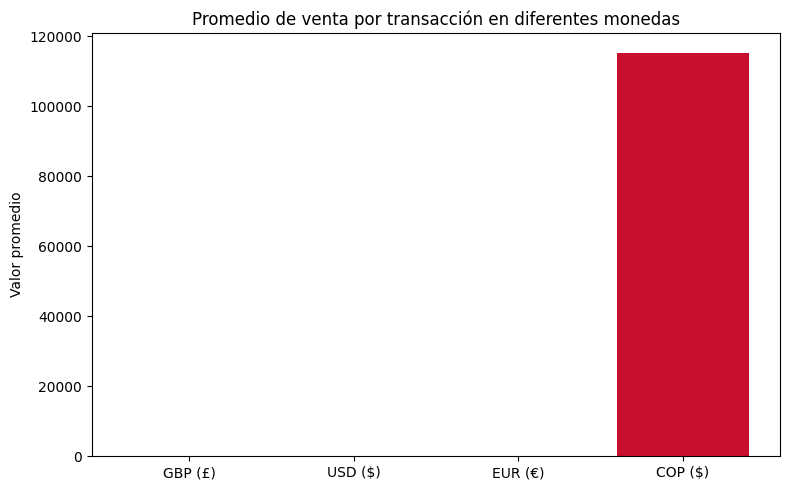

In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# --- Paso 1: Conectarse a la API Frankfurter ---
url = "https://api.frankfurter.app/latest?from=GBP&to=USD,EUR"
response = requests.get(url)

if response.status_code == 200:
    tasas = response.json()['rates']
    print("✅ Tasas de cambio actuales desde GBP:")
    print(tasas)
else:
    print("❌ Error al conectar con la API Frankfurter")

# --- Paso 2: Definir tasa manual USD → COP ---
usd_to_cop = 4200  # puedes actualizar este valor según la tasa actual

# --- Paso 3: Crear nuevas columnas con conversiones ---
df['Total_USD'] = df['Total'] * tasas['USD']
df['Total_EUR'] = df['Total'] * tasas['EUR']
df['Total_COP'] = df['Total_USD'] * usd_to_cop  # conversión indirecta

# --- Paso 4: Verificar las primeras filas ---
print("\nEjemplo de conversiones monetarias:")
print(df[['Total', 'Total_USD', 'Total_EUR', 'Total_COP']].head())

# --- Paso 5: Crear gráfico comparativo ---
promedios_moneda = {
    'GBP (£)': df['Total'].mean(),
    'USD ($)': df['Total_USD'].mean(),
    'EUR (€)': df['Total_EUR'].mean(),
    'COP ($)': df['Total_COP'].mean()
}

plt.figure(figsize=(8,5))
plt.bar(promedios_moneda.keys(), promedios_moneda.values(),
        color=['#005EB8', '#007849', '#F5A623', '#C8102E'])
plt.title('Promedio de venta por transacción en diferentes monedas')
plt.ylabel('Valor promedio')
plt.tight_layout()
plt.show()
